In [ ]:
!pip install -qU diffusers transformers accelerate insightface onnxruntime

# IP-Adapter

**IP-Adapter** is an image prompt adapter that can be plugged into diffusion models to enable image prompting without any changes to the underlying model. IP-Adapter can be reused with other models finetuned from the same base model and it can be combined with other adapters like `ControlNet`.

The key idea of IP-Adapter is the *decoupled cross-attention* mechanism which adds a separate cross-attention layer just for image features instead of using the same cross-attention layer for both text and image features. This allows the model to learn more image-specific features.

## General tasks

The `set_ip_adapter_scale()` method controls the amount of text or image conditioning to apply to the model.
* A value of `1.0` means the model is only conditioned on the image prompt.
* A value of `0.5` achieves a good balance between the two prompt types and produces good results.

We can try adding `low_cpu_mem_usage=True` argument to the `load_ip_adapter()` method to speed up the loading time.

##### Text-to-image

Adding an image alongside the text prompt helps the model better understand what it should generate and can lead to more accurate results.

In [ ]:
from diffusers import AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    'stabilityai/stable-diffusion-xl-base-1.0',
    torch_dtype=torch.float16,
).to('cuda')

pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='sdxl_models',
    weight_name='ip-adapter-sdxl.bin'
)
pipeline.set_ip_adapter_scale(0.6)

In [ ]:
ip_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_diner.png")
prompt = "a polar bear sitting in a chair drinking a milkshake"
generator = torch.Generator('cpu').manual_seed(111)

image = pipeline(
    prompt,
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    ip_adapter_image=ip_image,
    num_inference_steps=100,
    generator=generator,
).images[0]
make_image_grid([ip_image, image], rows=1, cols=2)

##### Image-to-image

IP-Adapter can also help with image-to-image by guiding the model to generate an image that resembles the original image and the image prompt.

In [ ]:
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid
import torch

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
).to("cuda")

pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='sdxl_models',
    weight_name='ip-adapter-sdxl.bin'
)
pipeline.set_ip_adapter_scale(0.6)

Providing a text prompt to the pipeline is optional, but here we use one to increase image quality.

In [ ]:
prompt = "best quality, high quality"

init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_bear_1.png")
ip_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_bear_2.png")
generator = torch.Generator('cpu').manual_seed(111)

image = pipeline(
    prompt,
    image=init_image,
    ip_adapter_image=ip_image,
    generator=generator,
    strength=0.6,
).images[0]
make_image_grid([init_image, ip_image, image], rows=1, cols=3)

##### Inpainting

In [ ]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import torch

pipeline = AutoPipelineForInpainting.from_pretrained(
    'diffusers/stable-diffusion-xl-1.0-inpainting-0.1',
    torch_dtype=torch.float16
).to('cuda')

pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='sdxl_models',
    weight_name='ip-adapter-sdxl.bin'
)
pipeline.set_ip_adapter_scale(0.6)

In [ ]:
mask_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_mask.png")
init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_bear_1.png")
ip_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_gummy.png")

prompt = 'a cute gummy bear waving'
generator = torch.Generator('cpu').manual_seed(111)

image = pipeline(
    prompt,
    image=init_image,
    mask_image=mask_image,
    ip_adapter_image=ip_image,
    generator=generator,
    num_inference_steps=100,
    strength=0.6,
).images[0]
make_image_grid([mask_image, init_image, ip_image, image], rows=1, cols=4)

##### Video

Here we need `AnimateDiff` with its motion adapter and insert an IP-Adapter into the model.

In [ ]:
from diffusers import AnimateDiffPipeline, DDIMScheduler, MotionAdapter
from diffusers.utils import export_to_gif, load_image
import torch

adapter = MotionAdapter.from_pretrained(
    'guoyww/animatediff-motion-adapter-v1-5-2',
    torch_dtype=torch.float16
)
pipeline = AnimateDiffPipeline.from_pretrained(
    'emilianJR/epiCRealism',
    motion_adapter=adapter,
    torch_dtype=torch.float16,
)
scheduler = DDIMScheduler.from_pretrained(
    'emilianJR/epiCRealism',
    subfolder='scheduler',
    clip_sample=False,
    timstep_spacing='linspace',
    beta_schedule='linear',
    steps_offset=1,
)
pipeline.scheduler = scheduler
pipeline.enable_vae_slicing()

pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='models',
    weight_name='ip-adapter_sd15.bin'
)
pipeline.enable_model_cpu_offload()

In [ ]:
ip_adapter_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_inpaint.png")
prompt = 'a cute gummy bear waving'
negative_prompt = 'bad quality, worse quality, low resolution'
generator = torch.Generator('cpu').manual_seed(111)

output = pipeline(
    prompt,
    negative_prompt=negative_prompt,
    ip_adapter_image=ip_adapter_image,
    num_frames=16,
    guidance_scale=7.5,
    num_inference_steps=50,
    generator=generator,
)
frames = output.frames[0]
export_to_gif(frames, 'output.gif')

## Configure parameters

### Image embeddings

IP-Adapter enabled pipelines provide the `ip_adapter_image_embeds` parameter to accept precomputed image embeddings. We will need this if we need to run the IP-Adapter pipeline multiple times because we have more than one image.

We can call the `prepare_ip_adapter_image_embeds()` method to encode and generate the image embeddings. Then we can save them

In [ ]:
from diffusers import AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    'stabilityai/stable-diffusion-xl-base-1.0',
    torch_dtype=torch.float16,
).to('cuda')

pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='sdxl_models',
    weight_name='ip-adapter-sdxl.bin'
)
pipeline.set_ip_adapter_scale(0.6)

In [ ]:
ip_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_diner.png")
prompt = "a polar bear sitting in a chair drinking a milkshake"
negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",

image_embeds = pipeline.prepare_ip_adapter_image_embeds(
    ip_adapter_image=ip_image,
    ip_adapter_image_embeds=None,
    device='cuda',
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
)

torch.save(image_embeds, 'image_embeds.ipadpt')

In [ ]:
# load it back
image_embeds = torch.load('image_embeds.ipadpt')

image = pipeline(
    prompt,
    negative_prompt=negative_prompt,
    ip_adapter_image_embeds=image_embeds,
    num_inference_steps=100,
    generator=generator,

).images[0]
image

### IP-Adapter masking

Binary masks specify which portion of the output image should be assigned to an IP-Adapter.

To start, we need to preprocess the input IP-Adapter images with the `IPAdapterMaskProcessor.preprocess()` to generate their masks.

In [ ]:
from diffusers.image_processor import IPAdapterMaskProcessor
from diffusers.utils import load_image, make_image_grid

mask1 = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_mask_mask1.png")
mask2 = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_mask_mask2.png")

output_height = 1024
output_width = 1024

processor = IPAdapterMaskProcessor()
masks = processor.preprocess(
    [mask1, mask2],
    height=output_height,
    width=output_width,
)

When there is more than one input IP-Adapter image, we load them as a list and provide the IP-Adapter scale list. Each of the input IP-Adapter images here corresponds to one of the masks generated above.

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    'stabilityai/stable-diffusion-xl-base-1.0',
    torch_dtype=torch.float16,
).to('cuda')

pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='sdxl_models',
    weight_name=['ip-adapter-plus-face_sdxl_vit-h.safetensors'] # pass as a list
)
pipeline.set_ip_adapter_scale([0.7, 0.7]) # one scale for each image-mask pair

In [ ]:
face_image1 = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_mask_girl1.png")
face_image2 = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_mask_girl2.png")

# prepare a list
ip_images = [[face_image1, face_image2]]

masks = [masks.reshape(1, masks.shape[0], masks.shape[2], masks.shape[3])]

Now we pass the preprocessed masks to `cross-attention_kwargs` in the pipeline call.

In [ ]:
prompt = '2 girls'
negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality"
generator = torch.Generator('cpu').manual_seed(111)
num_images = 1

image = pipeline(
    prompt,
    negative_prompt=negative_prompt,
    ip_adapter_image=ip_images,
    num_inference_steps=20,
    num_images_per_prompt=num_images,
    generator=generator,
    cross_attention_kwargs={'ip_adapter_masks': masks}
).images[0]

make_image_grid([mask1, mask2, face_image1, face_image2, image], rows=1, cols=5)

## Specific use cases

### Face model

* `ip-adapter-full-face_sd15.safetensors` is conditioned with images of cropped faces and removed backgrounds
* `ip-adapter-plus-face_sd15.safetensors` uses patch embeddings and is conditioned with images of cropped faces

Additionally, Diffusers supports all IP-Adapter checkpoints trained with face embeddings extracted by `insightface` models (in the [`h/94/IP-Adapter-FaceID`](https://huggingface.co/h94/IP-Adapter-FaceID) repository).

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image, make_image_grid

pipeline = StableDiffusionPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
).to('cuda')
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='models',
    weight_name='ip-adapter-full-face_sd15.bin'
)
pipeline.set_ip_adapter_scale(0.5)

  0%|          | 0/100 [00:00<?, ?it/s]

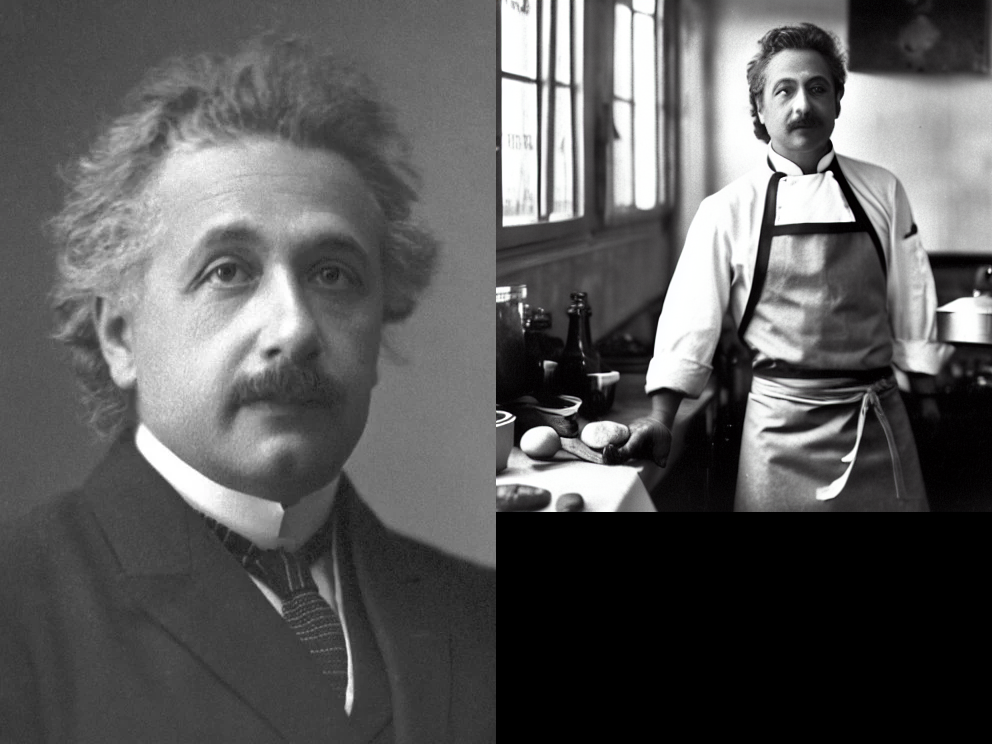

In [2]:
ip_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_einstein_base.png")
prompt = 'a photo of man as a chef, wearing an apron, cooking in a French restaurant'
generator = torch.Generator('cpu').manual_seed(111)

image = pipeline(
    prompt,
    negative_prompt='lowres, bad anatomy, worst quality, low quality',
    ip_adapter_image=ip_image,
    num_inference_steps=100,
    generator=generator,
).images[0]
make_image_grid([ip_image, image], rows=1, cols=2)

To use IP-Adapter FaceID models, first we need to extract face embeddings with `insightface`. Then pass the list of tensors to the pipeline as `ip_adapter_image_embeds`.

In [10]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image, make_image_grid
from insightface.app import FaceAnalysis
import cv2
import numpy as np

pipeline = StableDiffusionPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
).to('cuda')
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

pipeline.load_ip_adapter(
    'h94/IP-Adapter-FaceID',
    subfolder=None,
    weight_name='ip-adapter-faceid_sd15.bin',
    image_encoder_folder=None
)
pipeline.set_ip_adapter_scale(0.6)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

image_encoder is not loaded since `image_encoder_folder=None` passed. You will not be able to use `ip_adapter_image` when calling the pipeline with IP-Adapter.Use `ip_adapter_image_embeds` to pass pre-generated image embedding instead.


In [17]:
ip_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_mask_girl1.png")
ref_images_embeds = []

app = FaceAnalysis(
    name='buffalo_l',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
app.prepare(ctx_id=0, det_size=(640, 640))
ip_image_np = cv2.cvtColor(np.asarray(ip_image), cv2.COLOR_BGR2RGB)
faces = app.get(ip_image_np)
ip_image_np = torch.from_numpy(faces[0].normed_embedding)
ref_images_embeds.append(ip_image_np.unsqueeze(0))
ref_images_embeds = torch.stack(ref_images_embeds, dim=0).unsqueeze(0)
neg_ref_images_embeds = torch.zeros_like(ref_images_embeds)
id_embeds = torch.cat([neg_ref_images_embeds, ref_images_embeds]).to(dtype=torch.float16, device='cuda')

/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [18]:
prompt = 'a photo of a girl'
generator = torch.Generator('cpu').manual_seed(111)

image = pipeline(
    prompt,
    negative_prompt='monochrome, lowres, bad anatomy, worst quality, low quality',
    ip_adapter_image_embeds=[id_embeds],
    num_inference_steps=20,
    num_images_per_prompt=1,
    generator=generator,
).images[0]
make_image_grid([ip_image, image], rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.

Both [`IP-Adapter FaceID`](https://huggingface.co/h94/IP-Adapter-FaceID) Plus and Plus v2 models require CLIP image embeddings. We can prepare face embedings as shown previously, then we can extract and pass CLIP embeddings to the hidden image projection layers.

In [27]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image, make_image_grid
from insightface.app import FaceAnalysis
import cv2
import numpy as np

pipeline = StableDiffusionPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
).to('cuda')
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

pipeline.load_ip_adapter(
    'h94/IP-Adapter-FaceID',
    subfolder=None,
    weight_name='ip-adapter-faceid-plus_sd15.bin',
    image_encoder_folder=None
)
pipeline.set_ip_adapter_scale(0.6)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

image_encoder is not loaded since `image_encoder_folder=None` passed. You will not be able to use `ip_adapter_image` when calling the pipeline with IP-Adapter.Use `ip_adapter_image_embeds` to pass pre-generated image embedding instead.


In [ ]:
from insightface.utils import face_align

ref_images_embeds = []
ip_adapter_images = []
app = FaceAnalysis(
    name='buffalo_l',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
app.prepare(ctx_id=0, det_size=(640, 640))
ip_image_np = cv2.cvtColor(np.asarray(ip_image), cv2.COLOR_BGR2RGB)
faces = app.get(ip_image_np)
ip_adapter_images.append(face_align.norm_crop(ip_image_np, landmark=faces[0].kps, image_size=224))
ip_image_np = torch.from_numpy(faces[0].normed_embedding)
ref_images_embeds.append(ip_image_np.unsqueeze(0))
ref_images_embeds = torch.stack(ref_images_embeds, dim=0).unsqueeze(0)
neg_ref_images_embeds = torch.zeros_like(ref_images_embeds)
id_embeds = torch.cat([neg_ref_images_embeds, ref_images_embeds]).to(dtype=torch.float16, device='cuda')

clip_embeds = pipeline.prepare_ip_adapter_image_embeds(
    ip_adapter_image=None,
    ip_adapter_image_embeds=[id_embeds],
    device='cuda',
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
)[0]

pipeline.unet.encoder_hid_proj.image_projection_layers[0].clip_embeds = clip_embeds.to(dtype=torch.float16)
pipeline.unet.encoder_hid_proj.image_projection_layers[0].shortcut = False # True if Plus v2

### Multi IP-Adapter

More than one IP-Adapter can be used at the same time to generate specific images in more diverse styles.

Start by loading the image encoder with `CLIPVisionModelWithProjection`

In [ ]:
import torch
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from transformers import CLIPVisionModelWithProejection
from diffuers.utils import load_image, make_image_grid

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    'h94/IP-Adapter',
    subfolder='models/image_encoder',
    torch_dtype=torch.float16
)

Next to load a base model, a scheduler, and the IP-Adapters.

The IP-Adapters to use are passed as a list to the `weight_name`:
* `ip-adatper-plus_sdxl_vit-h` uses patch embeddings and a ViT-H image encoder
* `ip-adapter-plus-face_sdxl_vit-h` has the same architecture but it is conditioned with images of cropped faces

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
    'stabilityai/stable-diffusion-xl-base-1.0',
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='sdxl_models',
    weight_name=[
        'ip-adapter-plus_sdxl_vit-h.safetensors', # style
        'ip-adapter-plus-face_sdxl_vit-h.safetensors' # face
    ]
)

pipeline.set_ip_adapter_scale([0.7, 0.3]) # [style_weight, face_weight]
pipeline.enable_model_cpu_offload()

In [ ]:
# ip-image for face
face_image = load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/women_input.png")
# ip-images for styles
style_folder = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"
style_images = [load_image(f"{style_folder}/img{i}.png") for i in range(10)]

In [ ]:
prompt = 'wondoerwoman'
negative_prompt= 'monochrome, lowres, bad anatomy, worst quality, low quality'
generator = torch.Generator('cpu').manual_seed(111)

image = pipeline(
    prompt,
    negative_prompt=negative_prompt,
    ip_adapter_image=[
        style_images,
        face_image
    ],
    num_inference_steps=50,
    num_images_per_prompt=1,
    generator=generator
).images[0]
image

### Instant generation

**Latent Consistency Models (LCM)** are diffusion models that can generate images in as little as 4 steps compared to other diffusion models like SDXL.

IP-Adapters can be plugged into an LCM-LoRA model to instantly generate images with an image prompt.

The IP-Adapter weights need to be loaded first, then we can use `load_lora_weights()` to load the LoRA style and weight we want to apply to our image.

In [ ]:
import torch
from diffusers import DiffusionPipeline, LCMScheduler
from diffusers.utils import load_image, make_image_grid

model_id = 'sd-dreambooth-library/herge-style'
lcm_lora_id = 'latent-consistency/lcm-lora-sdv1-5'

pipeline = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
)

pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='models',
    weight_name='ip-adapter_sd15.bin'
)

pipeline.load_lora_weights(lcm_lora_id)

pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()

Use with a lower IP-Adapter scale to condition iamge generation more on the `herge_style` checkpoint.

In [ ]:
pipeline.set_ip_adapter_scale(0.4)

prompt = 'herge_style woman in armor, best quality, high quality'
generator = torch.Generator('cpu').manual_seed(111)

ip_adapter_image = load_image("https://user-images.githubusercontent.com/24734142/266492875-2d50d223-8475-44f0-a7c6-08b51cb53572.png")

image = pipeline(
    prompt,
    ip_adapter_image=ip_adapter_image,
    num_inference_steps=4,
    guidance_scale=1,
).images[0]
make_image_grid([ip_adapter_image, image], rows=1, cols=2)

### Structural control

IP-Adapter + ControlNet

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image, make_image_grid

controlnet_model_path = 'lllyasviel/control_v11f1p_sd15_depth'
controlnet = ControlNetModel.from_pretrained(
    controlnet_model_path,
    torch_dtype=torch.float16,
)

pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to('cuda')
pipeline.load_ip_adapter(
    'h94/IP-Adapter',
    subfolder='models',
    weight_name='ip-adapter_sd15.bin'
)

In [ ]:
ip_adapter_image = load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/statue.png")
depth_map = load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/depth.png")

prompt = 'best quality, high quality'
negative_prompt = 'monochrome, lowres, bad anatomy, worst quality, low quality'
generator = torch.Generator('cpu').manual_seed(111)

image = pipeline(
    prompt,
    negative_prompt=negative_prompt,
    image=depth_map,
    ip_adapter_image=ip_adapter_image,
    num_inference_steps=50,
    generator=generator,
).images[0]
make_image_grid([ip_adapter_image, depth_map, image], rows=1, cols=3)

### Style & layout control

**InstantStyle** is a plug-and-play method on top of IP-Adapter, which disentangles style and layout from image prompt to control image generation.

By default IP-Adapters are inserted to all layers of the model. Use the `set_ip_adapter_scale()` method with a dictionary to assign scales to IP-Adapter at different layers.

In [ ]:
from diffusers import AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
).to("cuda")
pipeline.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="sdxl_models",
    weight_name="ip-adapter_sdxl.bin"
)

In [ ]:
# custom scale
scale = {
    'down': {'block_2': [0.0, 1.0]},
    'up': {'block_0': [0.0, 1.0, 0.0]}
}
pipeline.set_ip_adapter_scale(scale)

This will activate IP-Adapter at the second layer in the model's down-part block 2 and up-part block 0.

In [ ]:
style_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg")

prompt="a cat, masterpiece, best quality, high quality"
negative_prompt="text, watermark, lowres, low quality, worst quality, deformed, glitch, low contrast, noisy, saturation, blurry"
generator = torch.Generator('cpu').manual_seed(111)

image = pipeline(
    prompt,
    negative_prompt=negative_prompt,
    ip_adapter_image=style_image,
    num_inference_steps=30,
    guidance_scale=5,
    generator=generator,
).imags[0]
make_image_grid([style_image, image], rows=1, cols=2)

In [ ]:
scale = {
    'up': {'block_0': [0., 1., 0.]}
}
pipeline.set_ip_adapter_scale(scale)

image = pipeline(
    prompt,
    negative_prompt=negative_prompt,
    ip_adapter_image=style_image,
    num_inference_steps=30,
    guidance_scale=5,
    generator=generator,
).imags[0]
make_image_grid([style_image, image], rows=1, cols=2)